## Load libraries and project modules

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from joblib import dump

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import ElasticNet, HuberRegressor, Lasso, LinearRegression, Ridge
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    OrdinalEncoder,
    OneHotEncoder,
    PolynomialFeatures,
    PowerTransformer,
    QuantileTransformer,
    RobustScaler,
    StandardScaler,
)

from src.config import CLEAN_DATA, LINEAR_REGRESSION_MODEL
from src.utils import coefficients_dataframe, CyclicalEncoder
from src.visualization import (
    PALETTE,
    plot_coefficients,
    plot_model_metrics_comparison,
    plot_residual_estimator,
    SCATTER_ALPHA
)

from src.models import (
grid_search_cv_regressor,
organize_cv_results,
train_and_validate_regression_model,
)

sns.set_theme(palette="bright")



## 1. Loading data and info display

In [2]:
df = pd.read_parquet(CLEAN_DATA)
display(df.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2696 entries, 2013-09-03 to 2025-04-16
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   boc1     2696 non-null   float64
 1   smc1     2696 non-null   float64
 2   sc1      2696 non-null   float64
 3   lcoc1    2696 non-null   float64
 4   hoc1     2696 non-null   float64
 5   fcpoc1   2696 non-null   float64
 6   cc1      2696 non-null   float64
 7   rsc1     2696 non-null   float64
 8   month    2696 non-null   int32  
 9   quarter  2696 non-null   int32  
dtypes: float64(8), int32(2)
memory usage: 210.6 KB


None

## 2. Feature Definition and Transformation Strategy

In this section, we define which column will be used as the target variable and categorize the input features based on the appropriate preprocessing strategy. 
- The `month` column is treated as a cyclical feature and will be encoded using sine and cosine transformations.
- All other numerical columns are scaled using a `RobustScaler` to reduce the impact of outliers.

In [3]:
target_column = ["boc1"]

cyclical_encoder_column = ["month"]

robust_scaler_columns = df.columns.difference(target_column + cyclical_encoder_column)

## 3. Preprocessing Pipeline

This cell defines the preprocessing steps to be applied to the features before modeling. It combines the cyclical encoder for the month column and a robust scaler for the remaining numerical features using a ColumnTransformer.



In [4]:
preprocessing = ColumnTransformer(
    transformers=[
        ("cyclical_encoder", CyclicalEncoder(period=12), cyclical_encoder_column),
        ("robust_scaler", RobustScaler(), robust_scaler_columns),
         ],
    remainder="passthrough" 
)


## 4. Define Feature Matrix (X) and Target Vector (y)
This cell separates the dataset into:

X: the input features used for training

y: the target variable to be predicted (boc1)



In [5]:
X = df.drop(columns=target_column)
y = df[target_column]

## 5. Define Combined Param Grid for Multiple Linear Models

This cell creates a parameter grid to compare several linear regression models, including Ridge, Lasso, ElasticNet, and Huber. The grid includes relevant hyperparameters for each model and will be used for cross-validation.


In [6]:
param_grid = [
    {
        "reg": [LinearRegression()]
    },
    {
        "reg": [Ridge()],
        "reg__alpha": [0.01, 0.1, 1.0, 10.0, 100.0]
    },
    {
        "reg": [Lasso()],
        "reg__alpha": [0.0001, 0.001, 0.01, 0.1, 1.0]
    },
    {
        "reg": [ElasticNet()],
        "reg__alpha": [0.0001, 0.001, 0.01, 0.1, 1.0],
        "reg__l1_ratio": [0.1, 0.5, 0.7, 0.9]
    },
    {
        "reg": [HuberRegressor()],
        "reg__epsilon": [1.35, 1.5, 1.75], 
        "reg__alpha": [0.0001, 0.001, 0.01]
    },
]

## 6. Initialize Grid Search for ElasticNet

This cell runs a `GridSearchCV` across multiple linear regression models and hyperparameters.  
We enable `return_train_score=True` to store training metrics along with validation results for further analysis.

In [7]:
grid_search = grid_search_cv_regressor(
    regressor=LinearRegression(), 
    param_grid=param_grid,
    preprocessor=preprocessing,
    return_train_score=True
)
grid_search

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('cyclical_encoder',
                                                                         CyclicalEncoder(period=12),
                                                                         ['month']),
                                                                        ('robust_scaler',
                                                                         RobustScaler(),
                                                                         Index(['cc1', 'fcpoc1', 'hoc1', 'lcoc1', 'quarter', 'rsc1', 'sc1', 'smc1'], dtype='object'))])),
                                       ('reg', Line...
                          'reg__alpha': [0.0001, 0.001, 0.01, 0.1, 1.0]},
                         {'reg': [ElasticNet()],
                          'reg__alpha': [0.0001, 0.001, 0.01, 0.1, 1.0],
                          'reg__l1_ratio': [0.1, 0.5, 0.7, 0.9]},
                         {'reg': [HuberRegressor()],
                          'reg__alpha': [0.0001, 0.001, 0.01],
                          'reg__epsilon': [1.35, 1.5, 1.75]}],
             refit='neg_root_mean_squared_error', return_train_score=True,
             scoring=['r2', 'neg_mean_absolute_error',
                      'neg_root_mean_squared_error'],
             verbose=1)

## 7. Fits the GridSearchCV using the training data.
This step evaluates all model and hyperparameter combinations defined in the parameter grid using cross-validation.

In [8]:
grid_search.fit(X, y)

Fitting 5 folds for each of 40 candidates, totalling 200 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('cyclical_encoder',
                                                                         CyclicalEncoder(period=12),
                                                                         ['month']),
                                                                        ('robust_scaler',
                                                                         RobustScaler(),
                                                                         Index(['cc1', 'fcpoc1', 'hoc1', 'lcoc1', 'quarter', 'rsc1', 'sc1', 'smc1'], dtype='object'))])),
                                       ('reg', Line...
                          'reg__alpha': [0.0001, 0.001, 0.01, 0.1, 1.0]},
                         {'reg': [ElasticNet()],
                          'reg__alpha': [0.0001, 0.001, 0.01, 0.1, 1.0],
                          'reg__l1_ratio': [0.1, 0.5, 0.7, 0.9]},
                         {'reg': [HuberRegressor()],
                          'reg__alpha': [0.0001, 0.001, 0.01],
                          'reg__epsilon': [1.35, 1.5, 1.75]}],
             refit='neg_root_mean_squared_error', return_train_score=True,
             scoring=['r2', 'neg_mean_absolute_error',
                      'neg_root_mean_squared_error'],
             verbose=1)

## 8. Review Best Parameters and Score

Displays the best hyperparameters and the corresponding RMSE obtained from cross-validation.

In [9]:
print("Best Model:", grid_search.best_estimator_.named_steps["reg"])
print("Hyperparameters:", grid_search.best_params_)
print("Best RMSE (CV):", -1 * grid_search.best_score_)

Best Model: Lasso(alpha=0.001)
Hyperparameters: {'reg': Lasso(), 'reg__alpha': 0.001}
Best RMSE (CV): 2.2630343646146236


## 9. Extract and Display Model Coefficients

Retrieves the feature names and corresponding coefficients from the best-performing regression model.  
This helps identify which features had the greatest impact on the model's predictions.

In [10]:
feature_names = []
best_model = grid_search.best_estimator_
regressor = best_model.named_steps["reg"]

# Cyclical features
cyclical_encoder = best_model.named_steps["preprocessor"].named_transformers_["cyclical_encoder"]
cyclical_features = cyclical_encoder.get_feature_names_out(["month"])
feature_names.extend(cyclical_features)

# Robust scaled features
robust_columns = best_model.named_steps["preprocessor"].transformers_[1][2]
feature_names.extend(robust_columns)

# Coeffs
coeffs = regressor.coef_

# Coeffs Dataframe
df_coeffs = coefficients_dataframe(coeffs, feature_names)
df_coeffs = df_coeffs.sort_values("coefficient", ascending=False)
df_coeffs

,coefficient
sc1,18.105209
hoc1,9.751130
rsc1,5.078577
fcpoc1,1.219019
month_cos,0.051290
quarter,-0.154724
cc1,-0.268297
month_sin,-1.147254
lcoc1,-6.310530
smc1,-7.628086


## 10. Plot Model Coefficients
Displays a horizontal bar chart of the coefficients from the best-performing regression model.

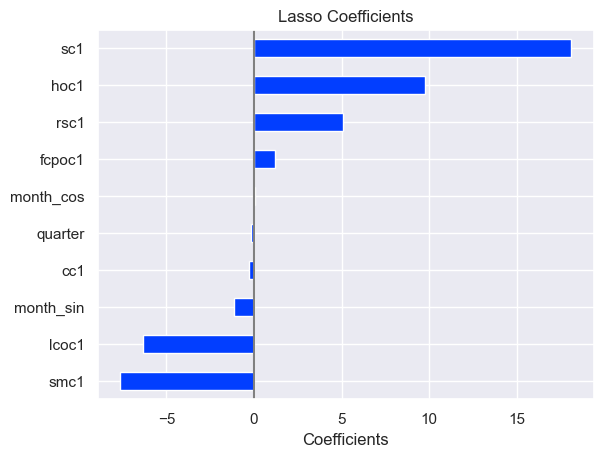

In [18]:
model_name = type(regressor).__name__
plot_coefficients(df_coeffs.sort_values('coefficient', ascending=True), title=f"{model_name} Coefficients")

## 11. Compare Baseline, Linear, and Tuned Models

This step compares the performance of a baseline model, a standard linear regression, and the best model obtained through grid search.  
All models are evaluated using cross-validation with consistent preprocessing steps.

In [19]:
# 1) Store the best-fitted pipeline
best_pipeline = grid_search.best_estimator_

# 2) Extract the name of the best model
best_model_name = type(best_pipeline.named_steps["reg"]).__name__

# 3) Define the models to compare
regressors = {
    "DummyRegressor": {
        "preprocessor": None,
        "regressor": DummyRegressor(strategy="mean"),
        "target_transformer": None,
    },
    "LinearRegression": {
        "preprocessor": preprocessing,
        "regressor": LinearRegression(),
        "target_transformer": None,
    },
    f"{best_model_name}_grid_search": {
        "preprocessor": best_pipeline.named_steps.get("preprocessor", None),
        "regressor": best_pipeline.named_steps["reg"],
        "target_transformer": None,
    },
}

# 4) Train and validate each model
results = {
    model_name: train_and_validate_regression_model(X, y, **cfg)
    for model_name, cfg in regressors.items()
}

# 5) Organize results into long-format DataFrame
df_results = organize_cv_results(results)
display(df_results)


,model,fit_time,score_time,test_r2,test_neg_mean_absolute_error,test_neg_root_mean_squared_error,time_seconds
0,DummyRegressor,0.002169,0.003557,-0.001123,-11.686747,-14.329131,0.005726
1,DummyRegressor,0.001739,0.00352,-0.000289,-11.3054,-13.663496,0.005259
2,DummyRegressor,0.00147,0.003177,-0.001498,-11.403468,-13.908046,0.004647
3,DummyRegressor,0.001599,0.003528,-0.002688,-11.442256,-14.394688,0.005126
4,DummyRegressor,0.001476,0.002087,-0.001123,-11.143407,-13.609337,0.003563
5,LinearRegression,0.006344,0.002752,0.97149,-1.685443,-2.418122,0.009096
6,LinearRegression,0.003839,0.003879,0.97488,-1.530174,-2.165259,0.007718
7,LinearRegression,0.004412,0.002519,0.974892,-1.546459,-2.202157,0.006932
8,LinearRegression,0.003739,0.002685,0.976385,-1.532821,-2.209091,0.006424
9,LinearRegression,0.004197,0.002514,0.970876,-1.634075,-2.321249,0.006712


## 12. Summarize and Compare Model Performance

This cell computes the average cross-validation metrics for each model and sorts them by RMSE.  
It helps compare the overall performance across baseline, linear, and tuned models.


In [20]:
df_results.groupby("model").mean().sort_values(by="test_neg_root_mean_squared_error")

,fit_time,score_time,test_r2,test_neg_mean_absolute_error,test_neg_root_mean_squared_error,time_seconds
model,,,,,,
DummyRegressor,0.00169,0.003174,-0.001344,-11.396256,-13.98094,0.004864
LinearRegression,0.004506,0.00287,0.973704,-1.585794,-2.263176,0.007376
Lasso_grid_search,0.003671,0.002669,0.973706,-1.585033,-2.263034,0.00634


## 13. Visualize Model Metrics Comparison

This chart displays a side-by-side comparison of model performance across key regression metrics using boxplots.  
It provides a visual understanding of the variability and average behavior of each model.


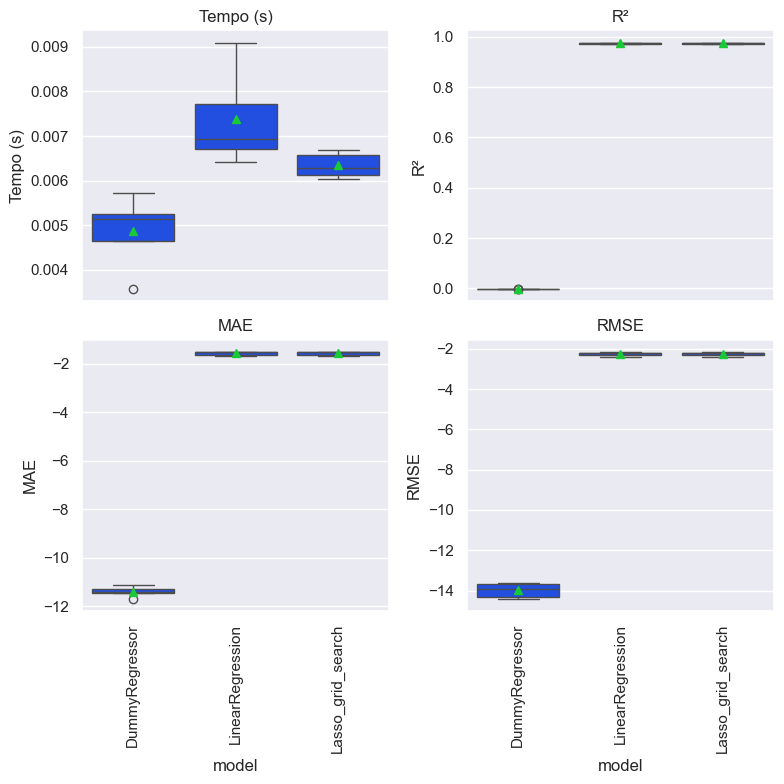

In [21]:
plot_model_metrics_comparison(df_results)

## 14. Residual Analysis for the Best Model

This plot shows the residual distribution, residuals vs predicted values, and predicted vs actual values for the best model.  
It helps diagnose potential issues such as non-linearity, heteroscedasticity, or systematic errors in predictions.


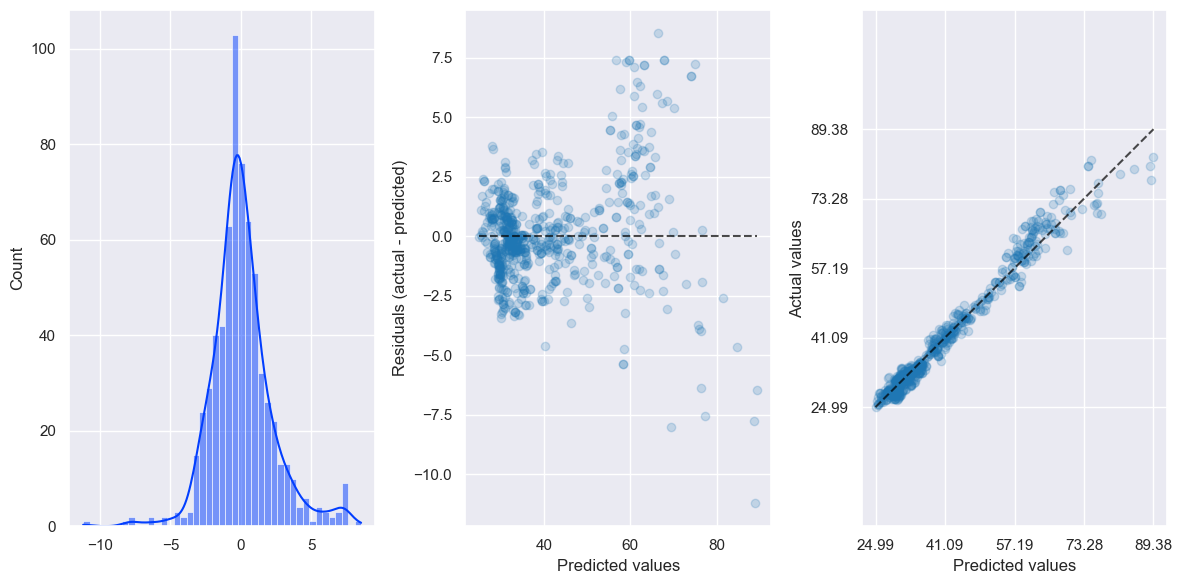

In [22]:
plot_residual_estimator(best_pipeline, X, y.values.ravel())

In [23]:
dump(grid_search.best_estimator_, LINEAR_REGRESSION_MODEL)

['C:\\Users\\d1eg0\\Desktop\\python\\Prediction\\spreads\\models\\linear_regression.joblib']